In [64]:
%matplotlib widget
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Figure formatting

In [2]:
# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Load data

In [65]:
df = pd.read_csv('data/m4_gaia.csv')

#keep only relevant columns
df = df[['index','x','y','r','phot_g_mean_mag','bp_rp','member']]

df = df.dropna() #drop missing values
df = df.set_index('index')
df = df.reset_index()

#rename columns
df.rename(columns = {'phot_g_mean_mag':'magnitude','bp_rp':'color'}, inplace = True) 

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89899 entries, 0 to 89898
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   index      89899 non-null  int64  
 1   x          89899 non-null  float64
 2   y          89899 non-null  float64
 3   r          89899 non-null  float64
 4   magnitude  89899 non-null  float64
 5   color      89899 non-null  float64
 6   member     89899 non-null  bool   
dtypes: bool(1), float64(5), int64(1)
memory usage: 4.2 MB


In [67]:
df.member.sum()/len(df)

0.21055851566758252

In [91]:
#stratified split between member and field stars
split = StratifiedShuffleSplit(n_splits=1,test_size=0.1,random_state=42)

for train_index, test_index in split.split(df,df['member']):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

#set index
strat_train_set = strat_train_set.set_index("index")
strat_test_set = strat_test_set.set_index("index")

member_labels = strat_train_set["member"].copy()*1

strat_train_set['member'].value_counts()/len(strat_train_set)

member
False    0.789442
True     0.210558
Name: count, dtype: float64

# Data cleaning

In [81]:
strat_train_set.describe()

,x,y,r,magnitude,color
count,80909.000000,80909.000000,80909.000000,80909.000000,80909.000000
mean,0.146534,-0.017249,2.603998,19.216515,1.483624
std,2.182082,1.997094,1.410940,1.595266,0.385515
min,-5.073131,-4.531386,0.006149,8.036979,-3.818037
25%,-1.249778,-1.333530,1.328558,18.279362,1.276394
50%,0.090290,-0.009015,2.705735,19.601944,1.427412
75%,1.603266,1.299085,3.858492,20.479378,1.660389
max,5.067380,4.538771,5.074620,22.085459,5.176950


## Preprocessing pipelines

In [88]:
num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", RobustScaler())
    ])

cat_pipeline = Pipeline([
        ("ordinal_encoder", OrdinalEncoder()),    
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse_output=False)),
    ])

# join numerical and categorical pipelines

num_attribs = ["x", "y", "r", "magnitude","color"]
cat_attribs = ["member"]

# preprocess_pipeline = ColumnTransformer([
#         ("num", num_pipeline, num_attribs),
#         ("cat", cat_pipeline, cat_attribs),
#     ])

preprocess_pipeline = ColumnTransformer([
         ("num", num_pipeline, num_attribs)])

In [92]:
X_train = preprocess_pipeline.fit_transform(strat_train_set.drop('member',axis=1))
y_train = member_labels

# Analysis

In [113]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score,cross_val_predict

In [94]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [96]:
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.9119504343286711

In [97]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.9033234916361614

## feature importances

In [106]:
sorted(zip(forest_clf.feature_importances_,
           strat_train_set.columns[:-1]),
           reverse=True)

[(0.33919255656245456, 'r'),
 (0.29934725122836253, 'magnitude'),
 (0.15773236445441718, 'color'),
 (0.10246900289205034, 'x'),
 (0.10125882486271558, 'y')]

In [105]:
strat_train_set.columns[:-1]

Index(['x', 'y', 'r', 'magnitude', 'color'], dtype='object')

In [107]:
forest_clf.feature_importances_

array([0.102469  , 0.10125882, 0.33919256, 0.29934725, 0.15773236])

In [114]:
y_train_pred = cross_val_predict(forest_clf,X_train,y_train,cv=3)

In [119]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [115]:
confusion_matrix(y_train,y_train_pred)

array([[60406,  3467],
       [ 3786, 13250]])

In [117]:
precision_score(y_train, y_train_pred)

0.792606328886762

In [118]:
recall_score(y_train, y_train_pred)

0.7777647335055178

In [120]:
f1_score(y_train, y_train_pred)

0.785115397149883

In [131]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train, y_train_pred)

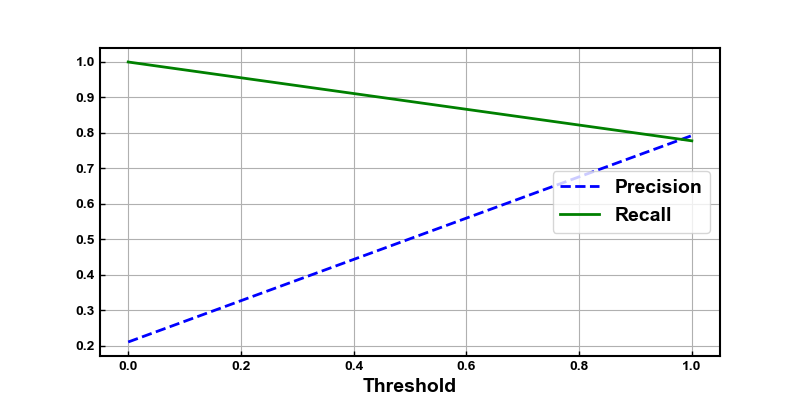

In [132]:
plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
# plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# extra code – this section just beautifies and saves Figure 3–5
# idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
# plt.plot(thresholds[idx], precisions[idx], "bo")
# plt.plot(thresholds[idx], recalls[idx], "go")
# plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")

plt.show()

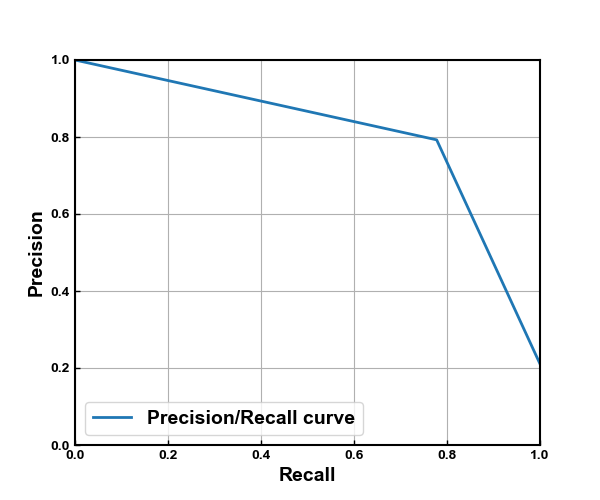

In [133]:
# import matplotlib.patches as patches  # extra code – for the curved arrow

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies and saves Figure 3–6
# plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
# plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
# plt.plot([recalls[idx]], [precisions[idx]], "ko",
        #  label="Point at threshold 3,000")
# plt.gca().add_patch(patches.FancyArrowPatch(
#     (0.79, 0.60), (0.61, 0.78),
#     connectionstyle="arc3,rad=.2",
#     arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
#     color="#444444"))
# plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
# save_fig("precision_vs_recall_plot")

plt.show()

In [136]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)

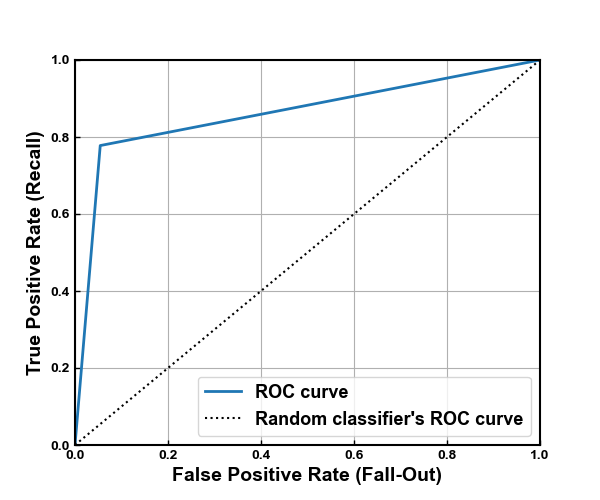

In [138]:
# idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
# tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
# plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# extra code – just beautifies and saves Figure 3–7
# plt.gca().add_patch(patches.FancyArrowPatch(
#     (0.20, 0.89), (0.07, 0.70),
#     connectionstyle="arc3,rad=.4",
#     arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
#     color="#444444"))
# plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
# save_fig("roc_curve_plot")

plt.show()

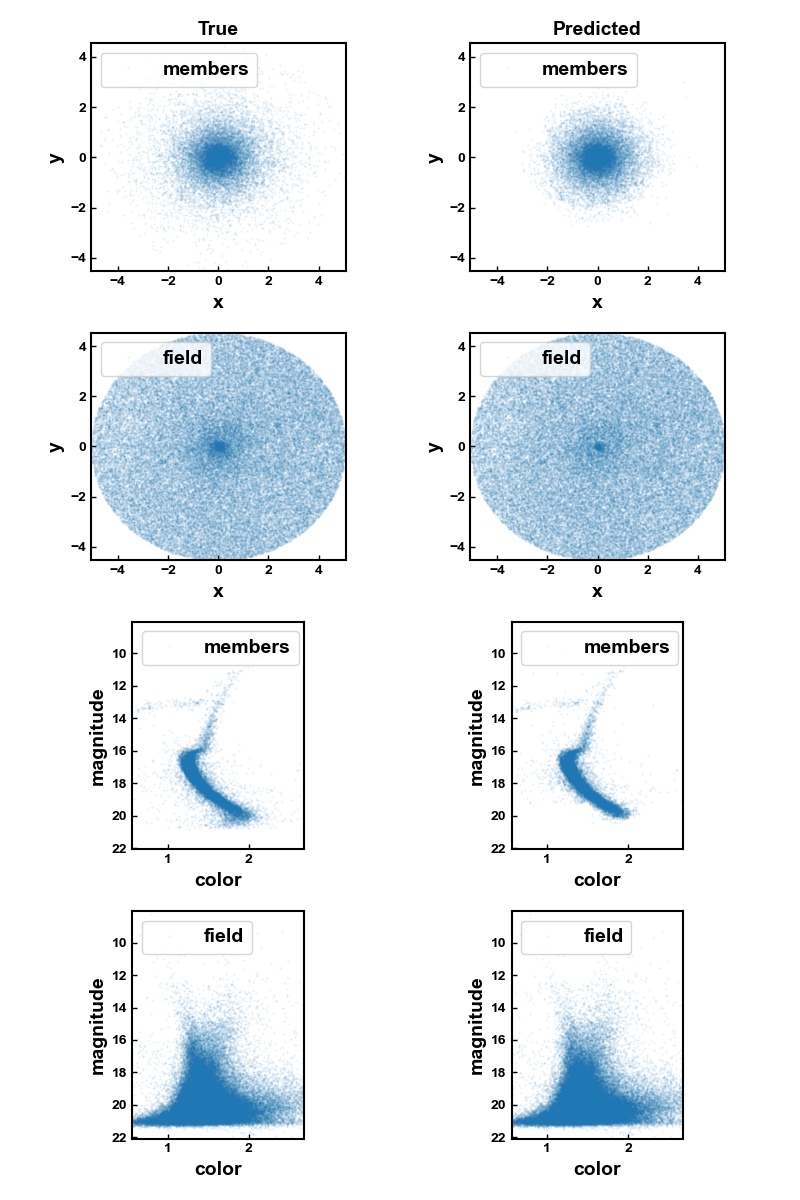

In [199]:
plt.close('all')
def myplot(row_number,xname,yname,pop,cmd=False):
    if pop=='members':
        _pop=1
    elif pop=='field':
        _pop=0
    else:
        print("pop must be 'members' or 'field'")
    ax[row_number,0].plot(strat_train_set[xname][y_train==_pop],strat_train_set[yname][y_train==_pop],'.',alpha=0.1,ms=1,label=pop)
    ax[row_number,1].plot(strat_train_set[xname][y_train_pred==_pop],strat_train_set[yname][y_train_pred==_pop],'.',alpha=0.1,ms=1,label=pop)
    if not cmd:
        ax[row_number,0].set_xlim(strat_train_set[xname].min(),strat_train_set[xname].max())
        ax[row_number,0].set_ylim(strat_train_set[yname].min(),strat_train_set[yname].max())
        ax[row_number,1].set_xlim(strat_train_set[xname].min(),strat_train_set[xname].max())
        ax[row_number,1].set_ylim(strat_train_set[yname].min(),strat_train_set[yname].max())
    else:
        ax[row_number,0].set_xlim(np.percentile(strat_train_set[xname],[1,99])) #.min(),strat_train_set[xname].max())
        ax[row_number,0].set_ylim(strat_train_set[yname].max(),strat_train_set[yname].min()) 
        ax[row_number,1].set_xlim(np.percentile(strat_train_set[xname],[1,99])) #.min(),strat_train_set[xname].max())
        ax[row_number,1].set_ylim(strat_train_set[yname].max(),strat_train_set[yname].min()) 
    ax[row_number,0].set_xlabel(xname)
    ax[row_number,0].set_ylabel(yname)
    ax[row_number,1].set_xlabel(xname)
    ax[row_number,1].set_ylabel(yname)
    ax[row_number,0].legend(loc='upper left')
    ax[row_number,1].legend(loc='upper left')

nrows = 4
ncols = 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, layout=None,figsize=(8,12))

myplot(0,'x','y',pop='members')
ax[0,0].set_aspect(1)
ax[0,1].set_aspect(1)
ax[0,0].set_title('True')
ax[0,1].set_title('Predicted')

myplot(1,'x','y',pop='field')
ax[1,0].set_aspect(1)
ax[1,1].set_aspect(1)

cmd_aspect = 0.2

myplot(2,'color','magnitude',pop='members',cmd=True)
ax[2,0].set_aspect(cmd_aspect)
ax[2,1].set_aspect(cmd_aspect)

myplot(3,'color','magnitude',pop='field',cmd=True)
ax[3,0].set_aspect(cmd_aspect)
ax[3,1].set_aspect(cmd_aspect)

fig.tight_layout()


In [139]:
plt.close('all')

(80909, 5)

In [179]:
strat_train_set.describe()

,x,y,r,magnitude,color
count,80909.000000,80909.000000,80909.000000,80909.000000,80909.000000
mean,0.146534,-0.017249,2.603998,19.216515,1.483624
std,2.182082,1.997094,1.410940,1.595266,0.385515
min,-5.073131,-4.531386,0.006149,8.036979,-3.818037
25%,-1.249778,-1.333530,1.328558,18.279362,1.276394
50%,0.090290,-0.009015,2.705735,19.601944,1.427412
75%,1.603266,1.299085,3.858492,20.479378,1.660389
max,5.067380,4.538771,5.074620,22.085459,5.176950


In [180]:
np.percentile(strat_train_set['color'],[5,95])

array([0.97941818, 2.15210802])